In [1]:
import numpy as np
import pandas as pd
import warnings
import h5py
import os
import yaml
import pickle
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import poisson, iqr
from scipy.optimize import curve_fit
from IPython.display import Image
from sklearn.metrics import mean_squared_error

Point these files and directories to the correct locations on NERSC or on an external drive, if the data was downloaded. 

In [2]:
DCA_800_FRAME_DATA_CSV_FILE = '/global/cfs/cdirs/m2043/balewski/neuronBBP-misc-8kHz/pred-info-169cell-800frames/pred-info-800frames-8kHz-T16_169cell.csv'
DCA_300_TO_700FRAME_DATA_CSV_DIR = '/global/cfs/cdirs/m2043/balewski/neuronBBP-misc-8kHz/pred-info-169cell-per1frame/'
CELL_SPECIFIC_DATA_DIR = '/global/cfs/cdirs/m2043/balewski/neuronBBP-data_67pr/'

DCA_800_FRAME_DATASET = pd.read_csv(DCA_800_FRAME_DATA_CSV_FILE)
print(DCA_800_FRAME_DATASET)

       # cellName  samples  inpDim   dca.d   dca.T     PI          jobID  \
0      #   bbp001      800      67       1      16   3.62   37401473/0/0   
1      #   bbp001      800      67       1      16   3.70  37401473/0/10   
2      #   bbp001      800      67       1      16   3.87  37401473/0/11   
3      #   bbp001      800      67       1      16   3.94   37401473/0/1   
4      #   bbp001      800      67       1      16   3.80   37401473/0/2   
...   ..      ...      ...     ...     ...     ...    ...            ...   
19638  #   bbp179      800      62      62      16  37.24  37420132/18/5   
19639  #   bbp179      800      62      62      16  41.91  37420132/18/6   
19640  #   bbp179      800      62      62      16  45.17  37420132/18/7   
19641  #   bbp179      800      62      62      16  45.52  37420132/18/8   
19642  #   bbp179      800      62      62      16  45.56  37420132/18/9   

       cov_time  fit_time   tot_time  
0           2.1       0.6        2.8  
1        

One of the objectives is to characterize cell types according to their predictive information. The code here scans the CSV file for the cell number (of the form bbpXXX) and groups them according to their type (L1, L23, L4, L5 or L6 neurons). 

In [3]:
# Each cell type Ln (n = 1, 23, 4, 5, 6) has an associated list of cell names of the form bbpXXX
SORTED_CELL_TYPES = {'L1' : [], 'L23' : [], 'L4' : [], 'L5' : [], 'L6' : []}
LOAD_SORTED_CELLS_FROM_FILE = True
CELL_TO_NEURONAL_TYPE = {}

# Store the sorted cell types in a .bin extension as a quick cache, so that we don't have to load the directories
if LOAD_SORTED_CELLS_FROM_FILE:
    with open("sorted-cell-types.bin", 'rb') as file:
        SORTED_CELL_TYPES = pickle.load(file)
    with open("cell-to-neuronal-type.bin", 'rb') as file:
        CELL_TO_NEURONAL_TYPE = pickle.load(file)
else:
    for cell in DCA_800_FRAME_DATASET['cellName'].unique():
        # read the metadata to see which cell type a cell name belongs to
        with open(CELL_SPECIFIC_DATA_DIR + cell + '/meta.cellSpike.yaml', 'r') as file:
            cell_info = yaml.safe_load(file)
        long_name = cell_info['rawInfo']['bbpName']
        cell_type = long_name[:2]
        if long_name[-5] == '2':
            CELL_TO_NEURONAL_TYPE[cell] = 'excitatory'
        else:
            CELL_TO_NEURONAL_TYPE[cell] = 'inhibitory'
        # a hack since we read only the first two characters of the name
        if cell_type == 'L2':
            cell_type = 'L23'
        SORTED_CELL_TYPES[cell_type].append(cell)
    # create a file so we don't have to keep accessing the metadata files
    with open("sorted-cell-types.bin", 'wb') as file:
        pickle.dump(SORTED_CELL_TYPES, file)
    with open("cell-to-neuronal-type.bin", 'wb') as file:
        pickle.dump(CELL_TO_NEURONAL_TYPE, file)
    
# This will be used later when we apply aggregate curve fitting
print(SORTED_CELL_TYPES)
print('\n')
print(CELL_TO_NEURONAL_TYPE)

{'L1': ['bbp001', 'bbp002', 'bbp003', 'bbp004', 'bbp005', 'bbp006', 'bbp007', 'bbp008', 'bbp009', 'bbp010', 'bbp011', 'bbp012', 'bbp013', 'bbp014'], 'L23': ['bbp017', 'bbp018', 'bbp019', 'bbp020', 'bbp023', 'bbp024', 'bbp025', 'bbp026', 'bbp027', 'bbp028', 'bbp031', 'bbp032', 'bbp034', 'bbp035', 'bbp036', 'bbp037', 'bbp038', 'bbp040', 'bbp041', 'bbp042', 'bbp043', 'bbp045', 'bbp046', 'bbp047', 'bbp048', 'bbp049', 'bbp050', 'bbp051', 'bbp052', 'bbp053', 'bbp054', 'bbp055', 'bbp056', 'bbp057'], 'L4': ['bbp060', 'bbp061', 'bbp062', 'bbp063', 'bbp066', 'bbp067', 'bbp068', 'bbp069', 'bbp070', 'bbp071', 'bbp072', 'bbp075', 'bbp076', 'bbp077', 'bbp078', 'bbp079', 'bbp080', 'bbp081', 'bbp082', 'bbp083', 'bbp084', 'bbp086', 'bbp087', 'bbp088', 'bbp089', 'bbp090', 'bbp091', 'bbp092', 'bbp093', 'bbp094', 'bbp095', 'bbp096', 'bbp097', 'bbp098', 'bbp099', 'bbp100', 'bbp101', 'bbp102'], 'L5': ['bbp106', 'bbp107', 'bbp108', 'bbp109', 'bbp111', 'bbp112', 'bbp113', 'bbp114', 'bbp115', 'bbp118', 'bbp119

The following is a sample of cell type. To maintain consistency, these were the same samples used by Jan Balewski in his analysis.

In [4]:
# Sample of cells of each type
L1_SAMPLE = ['bbp001', 'bbp003', 'bbp004', 'bbp007', 'bbp010', 'bbp014']
L23_SAMPLE = ['bbp020', 'bbp024', 'bbp031', 'bbp041', 'bbp050', 'bbp057']
L4_SAMPLE = ['bbp061', 'bbp063', 'bbp070', 'bbp079', 'bbp088', 'bbp101']
L5_SAMPLE = ['bbp107', 'bbp115', 'bbp129', 'bbp140', 'bbp148', 'bbp154']
L6_SAMPLE = ['bbp159', 'bbp171', 'bbp185', 'bbp194', 'bbp201', 'bbp203']

# 1. DCA Dimension vs Predictive Information Graphs (800 Frame Average)
For each simulated cell, and a given number of dynamical components, the predictive information (PI) was averaged over 800 frames for a total of 12 samples per cell and number of DCA dimensions (DCA d). The window size used to compute the dynamic components was 2ms (i.e. 16 bins). The following code allows comparison between the raw predictive information computed across different cells. Violin plots were used to account for the variance in the calculated predictive information for a given number of DCA components. 

The amount of predictive information gained by using a given number of dynamical components offers a crude method of comparing the complexities between cells. 

In [5]:
def graph_DCA_vs_PI(cell_names, img_width=6, img_height=4.5, cell_type='', labels_to_use=None, show_violins=True):
    '''
    Plots the DCA vs PI information for a given group of cells. 
    
    ARGS:
        cell_names : A list of cell names of the form 'bbpXXX' to graph
        img_width : Width of plot
        img_height : Height of plot
        cell_type : The cell type of the cells contained in cell_names. Default is empty string
        labels_to_use : A list of cell names to use instead of cell_names. Expected to be same length as cell_names
        show_violins : A boolean to include violin plots at each point to show variance and spread. 
                        Exists since there are multiple PI values for a given cell and DC value. 
    RETURNS:
        A plot of the absolute DC vs PI graphs for all the cells. 
    '''
    plt.figure(figsize=(img_width, img_height))
    DCA_800FRAME_DATA = pd.read_csv(DCA_800_FRAME_DATA_CSV_FILE)
    for i in range(len(cell_names)):
        # for each DC compute the mean PI across all provided cells
        dca_vs_pi_means= DCA_800FRAME_DATA[DCA_800FRAME_DATA['cellName'] == cell_names[i]].groupby(' dca.d')[' PI'].mean().to_frame().reset_index()
        # this gets all the PI values per DC to make the violin plot
        pi_corresponding_to_dim = DCA_800FRAME_DATA[DCA_800FRAME_DATA['cellName'] == cell_names[i]].groupby(' dca.d')[' PI'].apply(lambda x: x.values).values
        # decide which labels to use
        if labels_to_use != None:
            plt.plot(dca_vs_pi_means[' dca.d'], dca_vs_pi_means[' PI'], linestyle='dotted', marker='${}$'.format(i),label=labels_to_use[i])
        else: 
            plt.plot(dca_vs_pi_means[' dca.d'], dca_vs_pi_means[' PI'], linestyle='dotted', marker='${}$'.format(i),label=cell_names[i])
        if show_violins:
            # Make the violin plot appear at each point
            violin = plt.violinplot(pi_corresponding_to_dim, positions=dca_vs_pi_means[' dca.d'].unique(), widths=2, showextrema=False)
            # For making the violin the same color as the mean
            for param in violin['bodies']:
                param.set_facecolor(plt.gca().lines[-1].get_color())

    plt.xlabel('DCA d (dimension)')
    plt.ylabel('DCA Predictive Information (PI)')
    plt.title(cell_type + ': T = 2ms ({} bins), num_frames:{}, dataSets:{}'.format(16, 800, 12))
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return plt

## 1.1 Absolute Predictive Information
For comparison purposes, we find it important to make a distinction between absolute predictive information and normalized predictive information, which will be defined later. Absolute predictive information merely uses the exact predictive information calculated for the number of dynamical components in a cell type. 

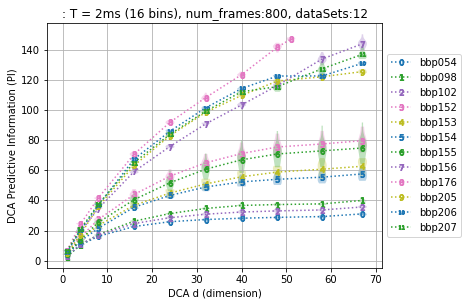

In [6]:
graph_DCA_vs_PI(['bbp054', 'bbp098', 'bbp102', 'bbp152', 'bbp153', 'bbp154', 'bbp155', 'bbp156', 'bbp176', 'bbp205', 'bbp206', 'bbp207']).show()

### 1.1.1 Plots of absolute PI over 800 frames for random inhibitory cells of certain types

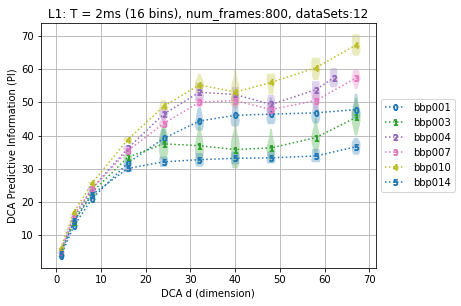

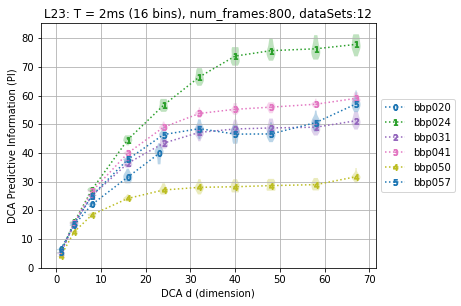

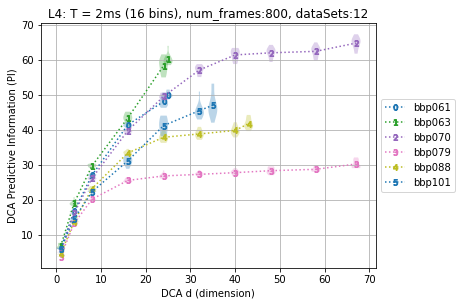

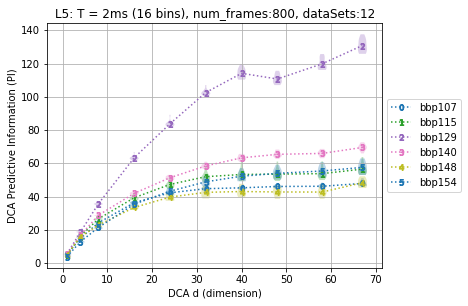

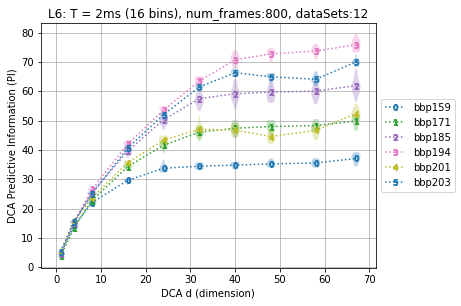

In [7]:
# L1
graph_DCA_vs_PI(L1_SAMPLE, cell_type = 'L1').show()
# L23
graph_DCA_vs_PI(L23_SAMPLE, cell_type = 'L23').show()
# L4
graph_DCA_vs_PI(L4_SAMPLE, cell_type = 'L4').show()
# L5
graph_DCA_vs_PI(L5_SAMPLE, cell_type = 'L5').show()
# L6
graph_DCA_vs_PI(L6_SAMPLE, cell_type = 'L6').show()

### 1.1.2 DCA vs PI plot of inhibitory vs excitatory and simple vs complex cells.

We can visualize the differences in DCA dimension vs predictive information across different cell types. Specficially, plots comparing inhibitory vs excitatory and simple vs complex cells are shown below. For this exact plot, cells bbp019, bbp027, bbp102, and bbp153 were compared against each other. The max average normalized graph of these same cells appears in the next section.

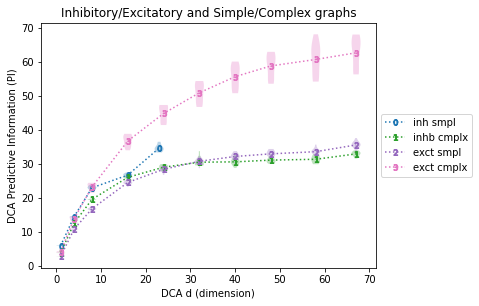

In [8]:
# graph to compate inhibitory vs excitatory and simple vs complex neuron types
DCA_vs_PI_signal_type = graph_DCA_vs_PI(['bbp019','bbp027','bbp102','bbp153'], labels_to_use=['inh smpl', 'inhb cmplx', 'exct smpl', 'exct cmplx'])
DCA_vs_PI_signal_type.title('Inhibitory/Excitatory and Simple/Complex graphs')
DCA_vs_PI_signal_type.grid(False)
DCA_vs_PI_signal_type.show()

### 1.1.3 DCA vs PI plot of Inhibitory vs Excitatory cells across all cells

In [9]:
def graph_DCA_vs_PI_inh_exc(cell_names, img_width=18, img_height=13.5, show_violins=True, normalizer='unnorm'):
    plt.figure(figsize=(img_width, img_height))
    DCA_800FRAME_DATA = pd.read_csv(DCA_800_FRAME_DATA_CSV_FILE)
    for i in range(len(cell_names)):
        # for each DC compute the mean PI across all provided cells
        dca_vs_pi_means= DCA_800FRAME_DATA[DCA_800FRAME_DATA['cellName'] == cell_names[i]].groupby(' dca.d')[' PI'].mean().to_frame().reset_index()
        dca_vs_pi_means['normalized PI'] = dca_vs_pi_means[' PI'] / dca_vs_pi_means[' PI'].max()
        # this gets all the PI values per DC to make the violin plot
        pi_corresponding_to_dim = DCA_800FRAME_DATA[DCA_800FRAME_DATA['cellName'] == cell_names[i]].groupby(' dca.d')[' PI'].apply(lambda x: x.values).values        
        # decide which labels to use
        color_to_use = None
        if CELL_TO_NEURONAL_TYPE[cell_names[i]] == 'inhibitory':
            if normalizer == 'unnorm':
                plt.plot(dca_vs_pi_means[' dca.d'], dca_vs_pi_means[' PI'], linestyle='--', color='black', marker="$0$")
            elif normalizer == 'maxavg':
                plt.plot(dca_vs_pi_means[' dca.d'], dca_vs_pi_means['normalized PI'], linestyle='--',color='black', marker="$0$")
            color_to_use = 'black'
        else:
            if normalizer == 'unnorm':
                plt.plot(dca_vs_pi_means[' dca.d'], dca_vs_pi_means[' PI'], linestyle=':',color='red', marker="$1$")
            elif normalizer == 'maxavg':
                plt.plot(dca_vs_pi_means[' dca.d'], dca_vs_pi_means['normalized PI'], linestyle=':',color='red', marker="$1$")
            color_to_use = 'red'
        if show_violins:
            # Make the violin plot appear at each point
            normalized_pi_corresponding_to_dim = pi_corresponding_to_dim / dca_vs_pi_means[' PI'].max()
            if normalizer == 'unnorm':
                violin = plt.violinplot(pi_corresponding_to_dim, positions=dca_vs_pi_means[' dca.d'].unique(), widths=2, showextrema=False)
            elif normalizer == 'maxavg':
                violin = plt.violinplot(normalized_pi_corresponding_to_dim, positions=dca_vs_pi_means[' dca.d'].unique(), widths=2, showextrema=False)
            # For making the violin the same color as the mean
            for param in violin['bodies']:
                param.set_facecolor(color_to_use)

    plt.xlabel('DCA d (dimension)')
    if normalizer == 'unnorm':
        plt.ylabel('DCA Predictive Information (PI)')
    elif normalizer == 'maxavg':
        plt.ylabel('DCA Relative Predictive Information (PI)')
    
    plt.title('Inhibitory vs Excitatory Neurons: T = 2ms ({} bins), num_frames:{}, dataSets:{}'.format(16, 800, 12))
    custom_legend1 = mlines.Line2D([], [], color='black', label='Inhibitory Neurons')
    custom_legend2 = mlines.Line2D([], [], color='red', label='Excitatory Neurons')
    # Add the custom legend entries to the plot
    plt.legend(handles=[custom_legend1, custom_legend2])
    
    plt.grid(True)
    return plt

<module 'matplotlib.pyplot' from '/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/matplotlib/pyplot.py'>

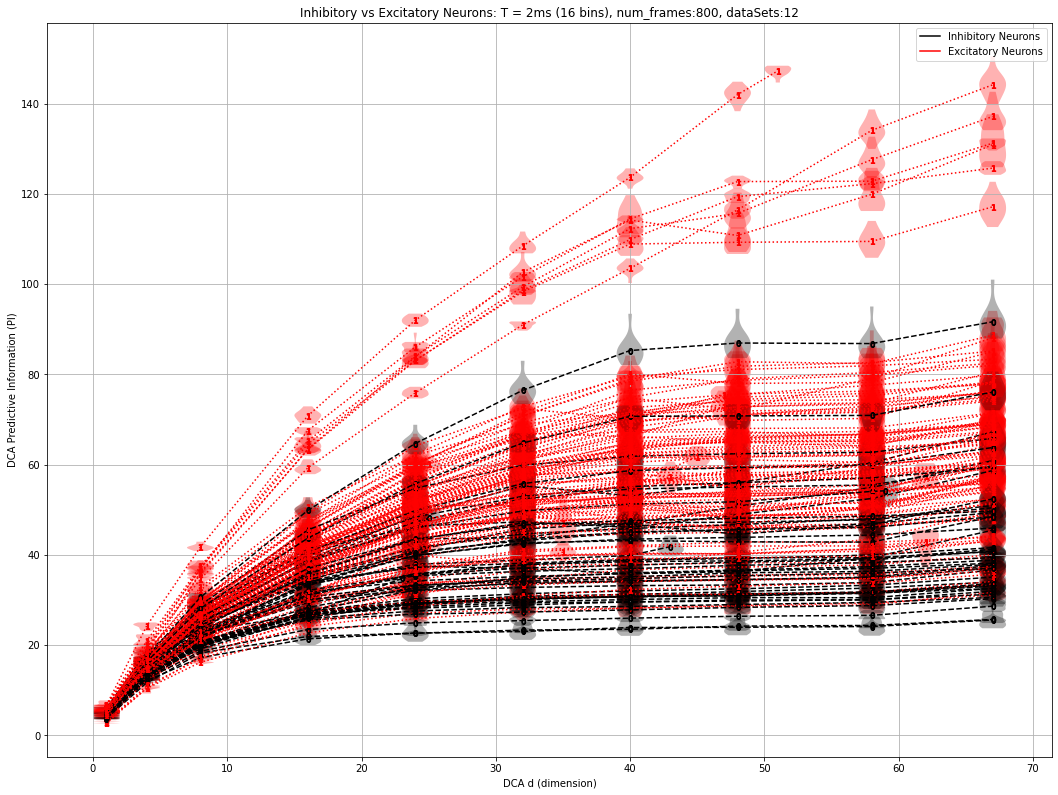

In [10]:
graph_DCA_vs_PI_inh_exc(list(CELL_TO_NEURONAL_TYPE.keys()))

## 1.2 Max Average Normalization

To accurately compare the complexities of neurons against each other, the amount of mutual information must be normalized. The relative information conent of the neurons were plotted by dividing the predicitve information by the mean predictive information for the largest available DCA dimension available for the given cell in the dataset. Mathematically, if $d_{max}$ denotes the largest available DCA dimension, and $I^{avg}_{d_{max}}$ denotes the mean predictive information for that specific dimension, then all provided values of predictive information for the cell were divided by $I^{avg}_{d_{max}}$. 

The relative predictive information allows us to see what percentage of the maximum information transmission is possible using just a certain number of dynamical components. 

In [11]:
def graph_DCA_vs_PI_maxavg_normalization(cell_names, sigma_scale=2, img_width=6, img_height=4.5, cell_type='', labels_to_use=None, show_violins=True):
    '''
    Plots the DCA vs relative PI information for a given group of cells. 
    
    ARGS:
        cell_names : A list of cell names of the form 'bbpXXX' to graph
        img_width : Width of plot
        img_height : Height of plot
        cell_type : The cell type of the cells contained in cell_names. Default is empty string
        labels_to_use : A list of cell names to use instead of cell_names. Expected to be same length as cell_names
        show_violins : A boolean to include violin plots at each point to show variance and spread. 
                        Exists since there are multiple PI values for a given cell and DC value. 
    RETURNS:
        A plot of the cells DC vs relative PI graphs. 
    '''
    plt.figure(figsize=(img_width, img_height))
    DCA_800FRAME_DATA = pd.read_csv(DCA_800_FRAME_DATA_CSV_FILE)
    for i in range(len(cell_names)):
        # for each DC compute the mean PI across all provided cells, and then normalize by largest
        dca_vs_pi_means= DCA_800FRAME_DATA[DCA_800FRAME_DATA['cellName'] == cell_names[i]].groupby(' dca.d')[' PI'].mean().to_frame().reset_index()
        dca_vs_pi_means['normalized PI'] = dca_vs_pi_means[' PI'] / dca_vs_pi_means[' PI'].max()
        # this gets all the PI values per DC to make the violin plot
        pi_corresponding_to_dim = DCA_800FRAME_DATA[DCA_800FRAME_DATA['cellName'] == cell_names[i]].groupby(' dca.d')[' PI'].apply(lambda x: x.values).values
        # decide which labels to use
        if labels_to_use == None:
            plt.plot(dca_vs_pi_means[' dca.d'], dca_vs_pi_means['normalized PI'], linestyle='dotted', marker='${}$'.format(i),label=cell_names[i])
        else:
            plt.plot(dca_vs_pi_means[' dca.d'], dca_vs_pi_means['normalized PI'], linestyle='dotted', marker='${}$'.format(i),label=labels_to_use[i])
        if show_violins:
            normalized_pi_corresponding_to_dim = pi_corresponding_to_dim / dca_vs_pi_means[' PI'].max()
            violin = plt.violinplot(normalized_pi_corresponding_to_dim, positions=dca_vs_pi_means[' dca.d'].unique(), widths=2, showextrema=False)
            # For making the violin the same color as the mean
            for param in violin['bodies']:
                param.set_facecolor(plt.gca().lines[-1].get_color())
            
    plt.xlabel('DCA d (dimension)')
    plt.ylabel('DCA Relative Predictive Information (PI)')
    plt.title(cell_type + ': T = 2ms ({} bins), num_frames:{}, dataSets:{}'.format(16, 800, len(cell_names)))
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return plt

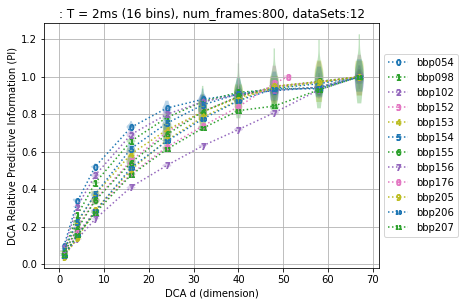

In [12]:
graph_DCA_vs_PI_maxavg_normalization(['bbp054', 'bbp098', 'bbp102', 'bbp152', 'bbp153', \
                                      'bbp154', 'bbp155', 'bbp156', 'bbp176', 'bbp205', 'bbp206', 'bbp207']).show()

### 1.2.1 Plots of relative PI over 800 frames for randomly sampled cells

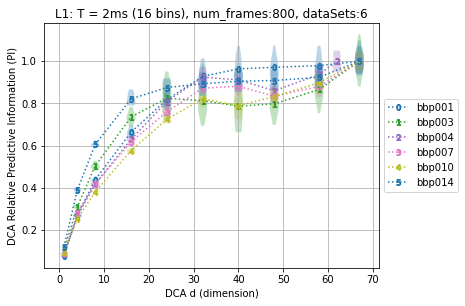

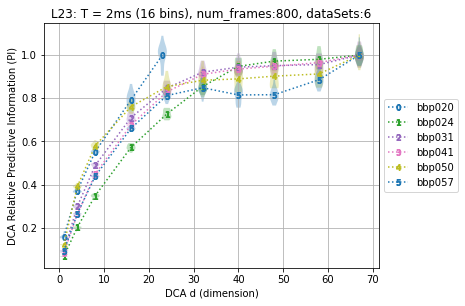

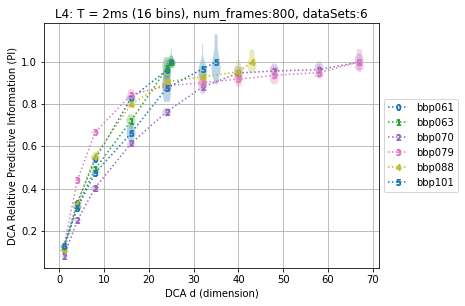

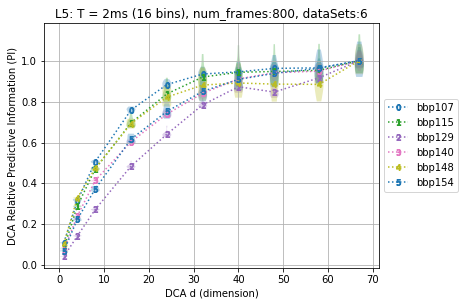

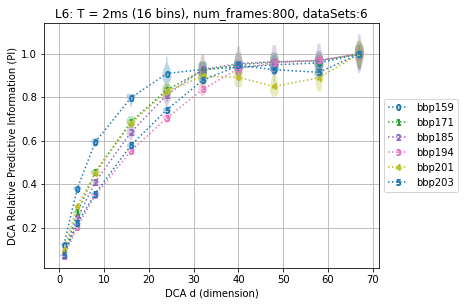

In [13]:
# L1
graph_DCA_vs_PI_maxavg_normalization(L1_SAMPLE, cell_type = 'L1').show()
# L23
graph_DCA_vs_PI_maxavg_normalization(L23_SAMPLE, cell_type = 'L23').show()
# L4
graph_DCA_vs_PI_maxavg_normalization(L4_SAMPLE, cell_type = 'L4').show()
# L5
graph_DCA_vs_PI_maxavg_normalization(L5_SAMPLE, cell_type = 'L5').show()
# L6
graph_DCA_vs_PI_maxavg_normalization(L6_SAMPLE, cell_type = 'L6').show()

### 1.2.2 Max Average normalization of inhibitory vs excitatory and simple vs complex cells

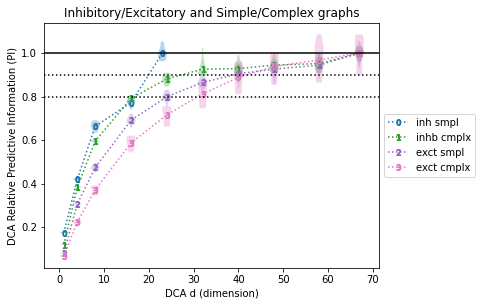

In [14]:
DCA_vs_PI_signal_type_normalized = graph_DCA_vs_PI_maxavg_normalization(['bbp019', 'bbp027', 'bbp102','bbp153'], \
                                                                        labels_to_use=['inh smpl', 'inhb cmplx', 'exct smpl', 'exct cmplx'])
DCA_vs_PI_signal_type_normalized.axhline(y=1, color='black')
DCA_vs_PI_signal_type_normalized.axhline(y=0.9, color='black', linestyle='dotted')
DCA_vs_PI_signal_type_normalized.axhline(y=0.8, color='black', linestyle='dotted')
DCA_vs_PI_signal_type_normalized.title('Inhibitory/Excitatory and Simple/Complex graphs')
DCA_vs_PI_signal_type_normalized.grid(False)
DCA_vs_PI_signal_type_normalized.show()

Each point on the graph can be thought of as measuring a fraction of the maximum amount of information that can be gained by obtaining more dimensions. The disadvantage of this method is that it is not clear why dividing by the largest mean predicitive information for each cell allows for comparison between cells. 

### 1.1.3 DCA vs Relative PI plot of Inhibitory vs Excitatory cells across all cells

<module 'matplotlib.pyplot' from '/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/matplotlib/pyplot.py'>

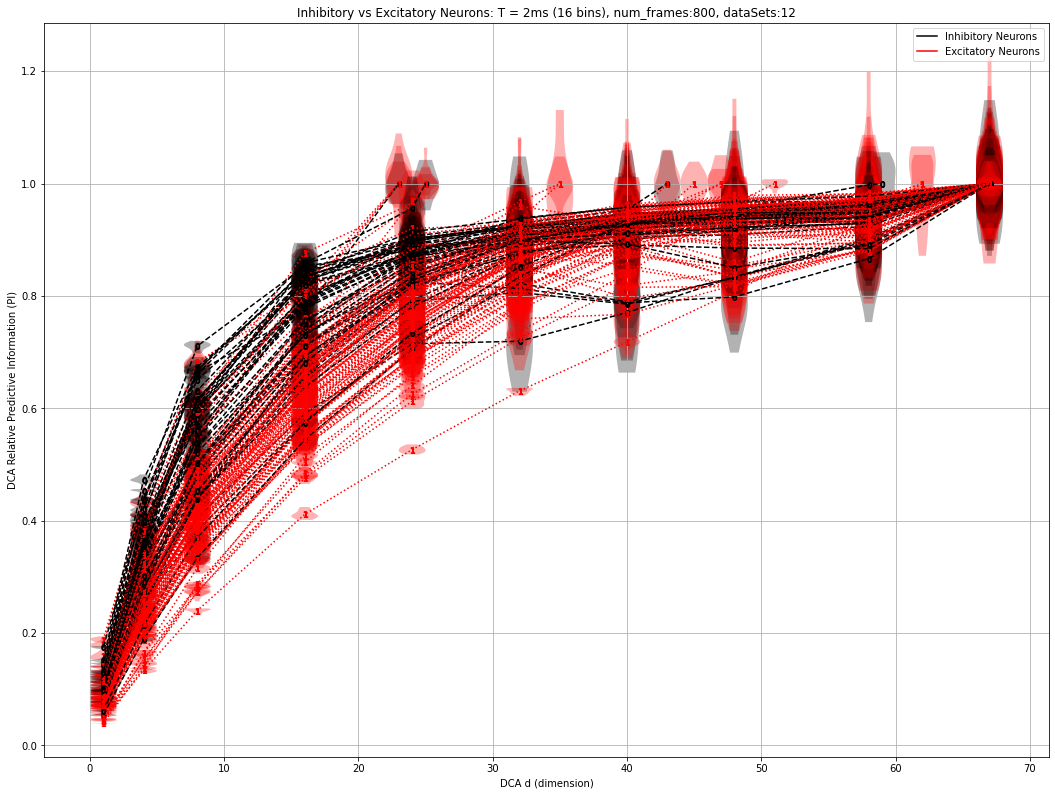

In [15]:
graph_DCA_vs_PI_inh_exc(list(CELL_TO_NEURONAL_TYPE.keys()), normalizer='maxavg')

# 2. Computing Thresholds and Curve-fitted Data

To compute the threshold of each neuron type, we apply two distinct methods. The first method involves obtaining all the data available for a certain neuron type and curve-fitting to the average of the aggregated data. The asymptote of the fitted curve is defined to be the information threshold for that neuron type. The complexity of the neuron is then defined as the number of dynamical components to cross that threshold. 

## 2.1 Threshold for Neuron Type

Given a cell type $T$, for each given DCA we compute the average predictive information across all cells of cell type $T$. Then, we apply a curve fit to the data. The threshold is defined as where the curve asymptotes. For a log and power fit, the asymptote is undefined, but for the other three types (rational, exponential and tanh), the threshold is defined. 

The exact exponential fit we used is of the form $y=A(1-e^{-Bx})$, the exact tanh fit we used was $y=A\tanh(Bx)$, and the exact rational fit we used was of the form $y=\frac{Ax+B}{Cx+D}$. 

The error bars added to the computed threshold were computed using the MSE of the curve fit. Specifically for a threshold $Y$ and MSE of $\sigma^2$, we plotted the errors $Y-\sigma$ and $Y+\sigma$. 

In [16]:
# this is used to compute thresholds for L1, L23, etc neurons.  
def curve_fit_params_DCA_vs_PI(cell_names, fit='exp', normalizer='maxavg'):
    '''
    Given a group of cell names, the function returns parameters and error of a curve fit to the average PI
    per DCA for the normalized or unnormalized data (if set to unnorm instead of maxavg).
    ARGS:
        cell_names : A list of cell names to curve fit to
        fit : Either log, pow, rat, exp or tanh fit to the average of the data
        normalizer : The normalization method to use. Pass unnorm for absolute data. 
    RETURNS:
        A dictionary with information regarding the fit type, the parametrized fit, the ground truth
        and estimate for the given DC's, the mean squared error of the fit, the parameters for the curves
        and the threshold (defined as the limit of the parametrized fit as the number of DC's approach infinity).
        
        For the fits log and pow, the threshold is np.inf, while for the others, the threshold is calculated using 
        standard techniques from calculus. 
        
    NOTES:
        The log fit parametrizes the data using y = A log x + B
        The power fit parametrizes the data using y = A * x^B
        The rational fit parametrizes the data using y = (Ax + B)/(Cx + D)
        The exponential fit parametrizes the data using y = A(1-e^(-Bx))
        The tanh fit parametrizes the data using y = A*tanh(Bx)
        
        When normalizer is set to maxavg, the exponential fit instead fits the curve to y = 1-e^(-Bx), however the function 
        still returns [1, B] for parameters (to keep consistency in the format). This is done to ensure that the fit does not 
        predict a normalized threshold larger than 1. We expect the threshold for maximal relative information to always equal
        1, so this is enforced. 
    '''
    
    grouped_data = DCA_800_FRAME_DATASET[DCA_800_FRAME_DATASET['cellName'].isin(cell_names)].groupby(['cellName', ' dca.d'])[' PI'].mean()
    dca_vs_pi_avg_across_cell_names = grouped_data.to_frame().reset_index()
    
    # Get's all the DC's available for the cell names (note different cell names have varying amounts of DC's available)
    X_dca = dca_vs_pi_avg_across_cell_names[' dca.d']
    X_fit = np.linspace(1, 67, 150)
    
    # Add the normalized PI to the dataframe if needed 
    if normalizer == 'maxavg':
        dca_vs_pi_avg_across_cell_names['normalized PI'] = dca_vs_pi_avg_across_cell_names.groupby('cellName')[' PI'].transform(lambda x: x / x.max())
        Y_pi = dca_vs_pi_avg_across_cell_names['normalized PI']
    else:
        Y_pi = dca_vs_pi_avg_across_cell_names[' PI']
        
    if fit == 'log':
        params, _ = curve_fit(lambda d, A, B: A * np.log(d) + B, X_dca, Y_pi)
        A = params[0]
        B = params[1] 
        Y_fit = A * np.log(X_fit) + B
        Y_pred = A * np.log(X_dca) + B
        
        return {'fit_type': fit, 
                'fit' : [X_fit, Y_fit], 
                'estimate' : [X_dca, Y_pred, Y_pi], 
                'MSE' : mean_squared_error(Y_pred, Y_pi), 
                'params' : [A, B], 
                'threshold' : np.inf}
    elif fit == 'rat':
        params, _ = curve_fit(lambda d, A, B, C, D: (A * d + B) / (C * d + D), X_dca, Y_pi, bounds=([0, np.inf]))
        A = params[0]
        B = params[1] 
        C = params[2]
        D = params[3]
        Y_fit = (A * X_fit + B) / (C * X_fit + D)
        Y_pred = (A * X_dca + B) / (C * X_dca + D)
        
        squared_loss = mean_squared_error(Y_pred, Y_pi)
        
        return {'fit_type': fit, 
                'fit' : [X_fit, Y_fit], 
                'estimate' : [X_dca, Y_pred, Y_pi], 
                'MSE' : squared_loss, 
                'params' : [A, B, C, D], 
                'threshold' : A / C}
    elif fit == 'pow':
        params, _ = curve_fit(lambda d, A, B: A * np.power(d, B), X_dca, Y_pi, bounds=([0, np.inf]))
        A = params[0]
        B = params[1] 
        Y_fit = A * np.power(X_fit, B)
        Y_pred = A * np.power(X_dca, B)
        
        return {'fit_type': fit, 
                'fit' : [X_fit, Y_fit], 
                'estimate' : [X_dca, Y_pred, Y_pi], 
                'MSE' : mean_squared_error(Y_pred, Y_pi), 
                'params' : [A, B], 
                'threshold' : np.inf}
    elif fit == 'exp':
        # If normalized is maxavg, then force A = 1 in the fit equation.
        if normalizer == 'maxavg':
            params, _ = curve_fit(lambda d, B: 1 - np.exp(- d * B), X_dca, Y_pi, bounds=([0, np.inf]))
            B = params[0]
            Y_fit = 1 - np.exp(- B * X_fit)
            Y_pred = 1 - np.exp(- B * X_dca)

            squared_loss = mean_squared_error(Y_pred, Y_pi)

            return {'fit_type': fit, 
                    'fit' : [X_fit, Y_fit], 
                    'estimate' : [X_dca, Y_pred, Y_pi], 
                    'MSE' : squared_loss, 
                    'params' : [1, B], 
                    'threshold' : 1}
        else:
            params, _ = curve_fit(lambda d, A, B: A * (1 - np.exp(- d * B)), X_dca, Y_pi, bounds=([0, np.inf]))
            A = params[0]
            B = params[1]
            Y_fit = A * (1 - np.exp(- B * X_fit))
            Y_pred = A * (1 - np.exp(- B * X_dca))

            squared_loss = mean_squared_error(Y_pred, Y_pi)

            return {'fit_type': fit, 
                    'fit' : [X_fit, Y_fit], 
                    'estimate' : [X_dca, Y_pred, Y_pi], 
                    'MSE' : squared_loss, 
                    'params' : [A, B], 
                    'threshold' : A}
    elif fit == 'tanh':
        params, _ = curve_fit(lambda d, A, B: A * np.tanh(B * d), X_dca, Y_pi)
        A = params[0]
        B = params[1]
        Y_fit = A * np.tanh(B * X_fit)
        Y_pred = A * np.tanh(B * X_dca)
        
        squared_loss = mean_squared_error(Y_pred, Y_pi)

        return {'fit_type': fit, 
                'fit' : [X_fit, Y_fit], 
                'estimate' : [X_dca, Y_pred, Y_pi], 
                'MSE' : squared_loss, 
                'params' : [A, B], 
                'threshold' : A}
    else:
        return 'Invalid flag for fit'

In [17]:
def curve_fit_plot_DCA_vs_PI(cell_names, cell_type, threshold_fit='exp', labels_to_use=None, normalizer='maxavg',
                             img_width=6, img_height=4.5, include_thresh=True, include_fit=True, show_violins=False):
    '''
    Plots the computed threshold and curve fit to the aggregate data. 
    ARGS:
        cell_names : A list of cell names to plot
        cell_type : The type corresponding to the list of cell names provided (expects L1, L23, etc)
        threshold_fit : The fit to use on the aggregate data to plot the threshold for the neuron class (same as cell type)
        labels_to_use : A list of labels to use instead of cell names
        normalizer : Expects either unnorm (which uses absolute data) or maxavg (which computes the max average of the data 
                     as described above
        img_width : Width of image
        img_height : Height of image
        include_thresh : A boolean value on whether or not to include the threshold in the plot
        include_fit : A boolean value on whether or not to include the curve fit in the plot
        show_violins : A boolean value on whether or not to show the violin plots per DC. 
    RETURNS:
        None. Displays a matplotlib graph. 
    NOTES:
        The threshold is calculated based on ALL cells of type cell_type, not just those provided in cell_names
    '''
    # Make the parametrize curves based on ALL the data of cell_type, but only plot those
    param_data = curve_fit_params_DCA_vs_PI(SORTED_CELL_TYPES[cell_type], fit=threshold_fit, normalizer=normalizer)
    threshold = param_data['threshold']
    error = np.sqrt(param_data['MSE'])
    
    X_fit, Y_fit = param_data['fit']
    
    if normalizer == 'maxavg':
        dca_vs_pi_plot = graph_DCA_vs_PI_maxavg_normalization(cell_names, img_width=img_width, img_height=img_height, 
                                                              cell_type=cell_type, labels_to_use=labels_to_use, show_violins=show_violins)
    else: 
        dca_vs_pi_plot = graph_DCA_vs_PI(cell_names, img_width=img_width, img_height=img_height,
                                         cell_type=cell_type, labels_to_use=labels_to_use, show_violins=show_violins)
    
    if include_fit:
        dca_vs_pi_plot.plot(X_fit, Y_fit, linewidth=2, color='black')
        
    if include_thresh and threshold < np.inf:
        dca_vs_pi_plot.axhline(y=threshold, color='black')
        dca_vs_pi_plot.axhline(y=threshold + error, color='black', linestyle='dashed')
        dca_vs_pi_plot.axhline(y=threshold - error, color='black', linestyle='dashed')
            
    dca_vs_pi_plot.title(threshold_fit + ' fit - ' + cell_type + ': T = 2ms ({} bins), num_frames:{}, dataSets:{}'.format(16, 800, len(cell_names)))
    dca_vs_pi_plot.show()

### 2.1.1 DCA vs PI graphs of Samples of L1, L23, L4, L5 and L6 neuron types overlaid by computed threshold

In the graphs below, we plot a sample of cell types as well as the information threshold predicted for each cell type. 

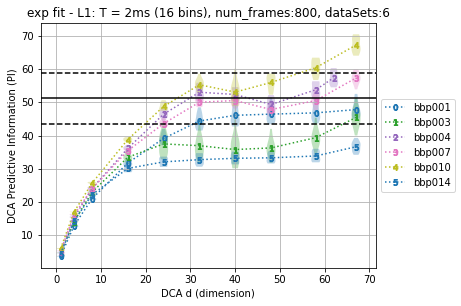

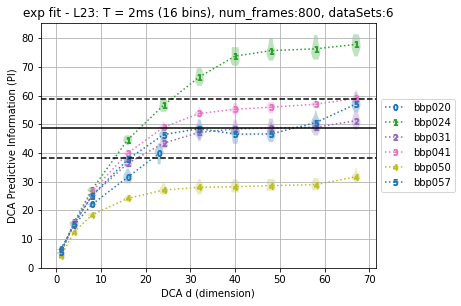

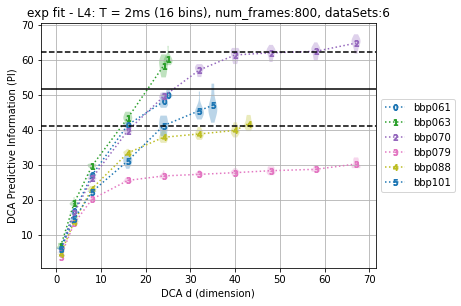

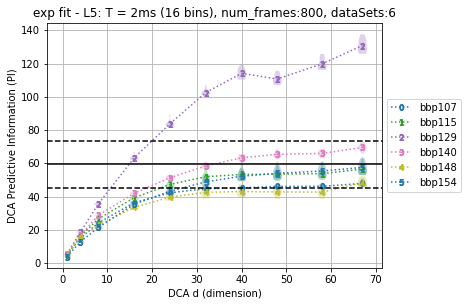

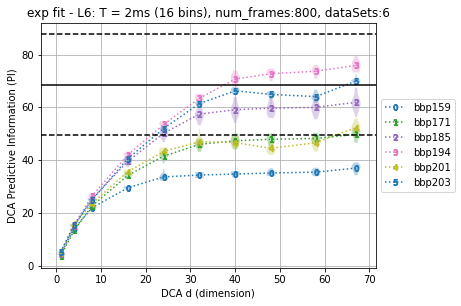

In [18]:
L1_SAMPLE = ['bbp001', 'bbp003', 'bbp004', 'bbp007', 'bbp010', 'bbp014']
L23_SAMPLE = ['bbp020', 'bbp024', 'bbp031', 'bbp041', 'bbp050', 'bbp057']
L4_SAMPLE = ['bbp061', 'bbp063', 'bbp070', 'bbp079', 'bbp088', 'bbp101']
L5_SAMPLE = ['bbp107', 'bbp115', 'bbp129', 'bbp140', 'bbp148', 'bbp154']
L6_SAMPLE = ['bbp159', 'bbp171', 'bbp185', 'bbp194', 'bbp201', 'bbp203']
    
curve_fit_plot_DCA_vs_PI(L1_SAMPLE, 'L1', normalizer='unnorm', include_fit=False, show_violins=True)
curve_fit_plot_DCA_vs_PI(L23_SAMPLE, 'L23', normalizer='unnorm', include_fit=False, show_violins=True)
curve_fit_plot_DCA_vs_PI(L4_SAMPLE, 'L4', normalizer='unnorm', include_fit=False, show_violins=True)
curve_fit_plot_DCA_vs_PI(L5_SAMPLE, 'L5', normalizer='unnorm', include_fit=False, show_violins=True)
curve_fit_plot_DCA_vs_PI(L6_SAMPLE, 'L6', normalizer='unnorm', include_fit=False, show_violins=True)

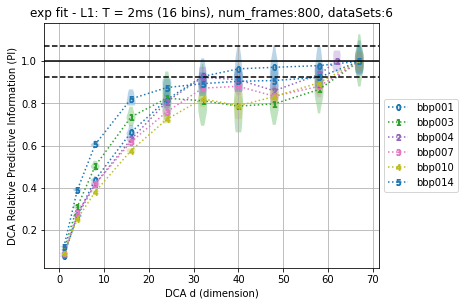

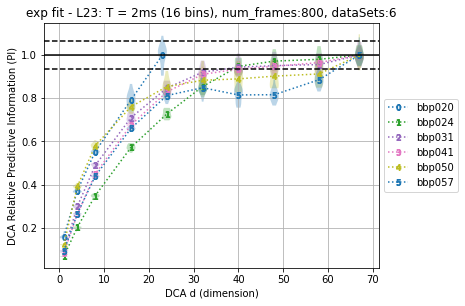

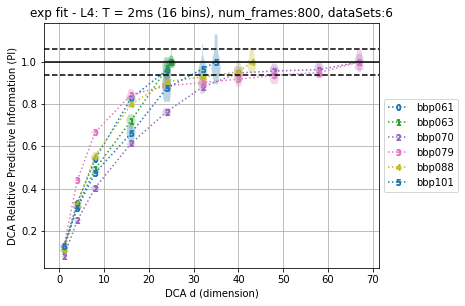

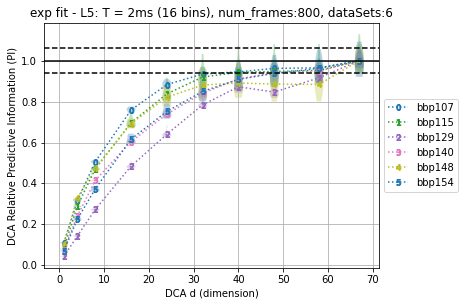

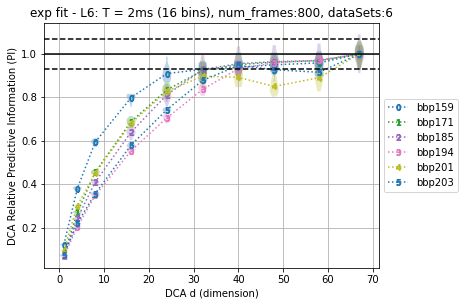

In [19]:
curve_fit_plot_DCA_vs_PI(L1_SAMPLE, 'L1', normalizer='maxavg', include_fit=False, show_violins=True)
curve_fit_plot_DCA_vs_PI(L23_SAMPLE, 'L23', normalizer='maxavg', include_fit=False, show_violins=True)
curve_fit_plot_DCA_vs_PI(L4_SAMPLE, 'L4', normalizer='maxavg', include_fit=False, show_violins=True)
curve_fit_plot_DCA_vs_PI(L5_SAMPLE, 'L5', normalizer='maxavg', include_fit=False, show_violins=True)
curve_fit_plot_DCA_vs_PI(L6_SAMPLE, 'L6', normalizer='maxavg', include_fit=False, show_violins=True)

When we parametrize the DCA vs PI plot of a cell, we also include error bars that are computed by taking the square root of the MSE of the fit. These error bars are plotted on the parametrized curve along the provided DCA's in the data. 

## 2.2 Individually Parametrizing Neurons

For each neuron we replace its graph with a parametrized fit to see the DC value corresponding to the first crossing of the threshold. The graphs below parametrize the cells with log fits, so that a crossing exists (the crossing might not exist for any fit with an asymptote since the values saturate at the asymptote). 

In [20]:
def curve_fit_parameterized_plot_DCA_vs_PI(cell_names, cell_type, fit='exp', threshold_fit='exp', labels_to_use=None, normalizer='maxavg',
                             img_width=6, img_height=4.5, include_thresh=True, include_fit=True, show_violins=False,
                             include_ground_truth=False):
    
    param_data = curve_fit_params_DCA_vs_PI(SORTED_CELL_TYPES[cell_type], fit=threshold_fit, normalizer=normalizer)
    threshold = param_data['threshold']
    error = np.sqrt(param_data['MSE'])
    X_fit, Y_fit = param_data['fit']
        
    plt.figure(figsize=(img_width, img_height))
    
    DCA_for_thresh = {}
    MSE_per_cell = {}
    
    for cell in cell_names:
        param_data_cell = curve_fit_params_DCA_vs_PI([cell], fit=fit, normalizer=normalizer)     
        error_cell = np.sqrt(param_data_cell['MSE'])
        X_fit_cell, Y_fit_cell = param_data_cell['fit']
        X_dca, Y_pred, Y_pi = param_data_cell['estimate']
        fit_params = param_data_cell['params']
        
        MSE_per_cell[cell] = error_cell ** 2
        
        plt.plot(X_fit_cell, Y_fit_cell, label=cell)
        plt.errorbar(X_dca, Y_pred, yerr=error_cell, capsize=2, linestyle='none', marker='o', markersize=3, color=plt.gca().lines[-1].get_color())
        if include_ground_truth:
            plt.plot(X_dca, Y_pi, linestyle='dotted', color=plt.gca().lines[-1].get_color(), marker='o')
        
        if fit == 'log':
            DCA_for_thresh[cell] = []
            for thresh in [threshold - error_cell, threshold, threshold + error_cell]:
                DCA_for_thresh[cell].append(np.ceil(np.exp((thresh - fit_params[1]) / fit_params[0])))
        elif fit == 'exp':
            DCA_for_thresh[cell] = []
            for thresh in [threshold - error_cell, threshold, threshold + error_cell]:
                if thresh < fit_params[0]:
                    DCA_for_thresh[cell].append(np.ceil(-1 / fit_params[1] * np.log(1 - thresh / fit_params[0])))
                else:
                    DCA_for_thresh[cell].append(np.inf)
                    
    if include_fit:
        plt.plot(X_fit, Y_fit, linewidth=2, color='black')
        
    if include_thresh and threshold < np.inf:
        plt.axhline(y=threshold, color='black')
        plt.axhline(y=threshold + error, color='black', linestyle='dashed')
        plt.axhline(y=threshold - error, color='black', linestyle='dashed')
        
    plt.xlabel('DCA d (dimension)')
    plt.ylabel('DCA Relative Predictive Information (PI)')
    plt.title(fit + ' fit, ' + threshold_fit + ' threshold' + ' - ' + cell_type + ': T = 2ms ({} bins), num_frames:{}, dataSets:{}'.format(16, 800, len(cell_names)))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
    return DCA_for_thresh, MSE_per_cell

### 2.2.1 Using log fits to visualize the crossings

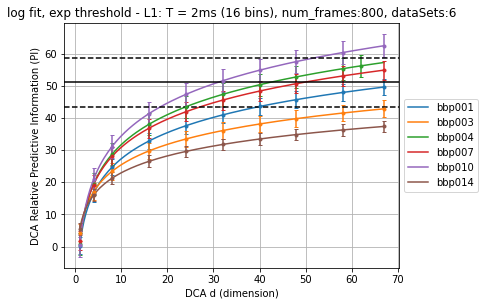

({'bbp001': [62.0, 77.0, 95.0], 'bbp003': [124.0, 166.0, 221.0], 'bbp004': [33.0, 43.0, 55.0], 'bbp007': [40.0, 50.0, 63.0], 'bbp010': [25.0, 32.0, 40.0], 'bbp014': [322.0, 411.0, 523.0]}, {'bbp001': 6.545918614796387, 'bbp003': 6.903910286191523, 'bbp004': 11.969833346234806, 'bbp007': 8.882537589005047, 'bbp010': 12.632461272038107, 'bbp014': 3.387652130539118})


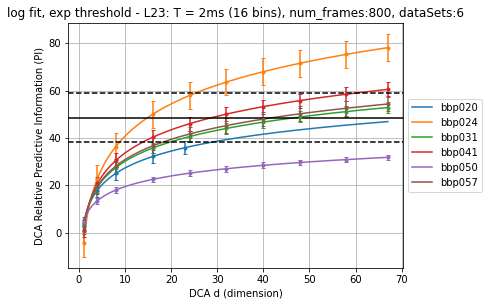

({'bbp020': [60.0, 79.0, 105.0], 'bbp024': [12.0, 15.0, 20.0], 'bbp031': [39.0, 47.0, 57.0], 'bbp041': [24.0, 29.0, 36.0], 'bbp050': [741.0, 889.0, 1065.0], 'bbp057': [33.0, 43.0, 55.0]}, {'bbp020': 8.332343025741045, 'bbp024': 31.906783417255408, 'bbp031': 5.351902584858917, 'bbp041': 8.82066477807574, 'bbp050': 1.3931103918901708, 'bbp057': 9.667089545720621})


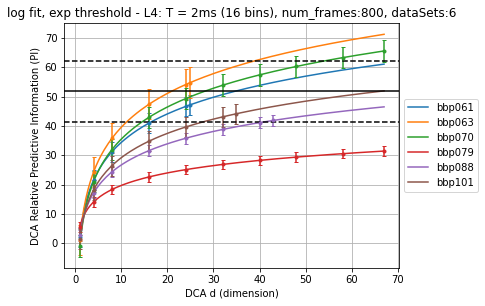

({'bbp061': [28.0, 35.0, 44.0], 'bbp063': [16.0, 21.0, 29.0], 'bbp070': [23.0, 29.0, 36.0], 'bbp079': [1406.0, 1816.0, 2345.0], 'bbp088': [94.0, 112.0, 132.0], 'bbp101': [50.0, 66.0, 88.0]}, {'bbp061': 11.236745417831173, 'bbp063': 26.261587233044192, 'bbp070': 13.375923421196617, 'bbp079': 2.478428448390942, 'bbp088': 3.1990127489207385, 'bbp101': 11.530604250132567})


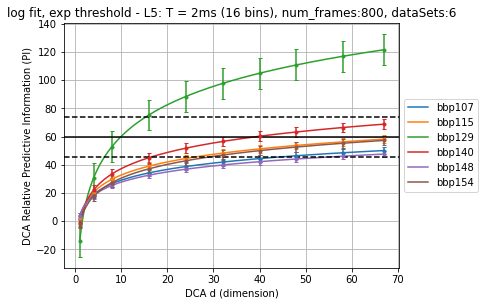

({'bbp107': [125.0, 156.0, 194.0], 'bbp115': [61.0, 74.0, 90.0], 'bbp129': [7.0, 10.0, 14.0], 'bbp140': [31.0, 39.0, 47.0], 'bbp148': [171.0, 208.0, 254.0], 'bbp154': [62.0, 79.0, 99.0]}, {'bbp107': 5.976805943911371, 'bbp115': 6.983235689214166, 'bbp129': 120.02612830704999, 'bbp140': 11.80614960728639, 'bbp148': 4.380852643671712, 'bbp154': 10.637492433232016})


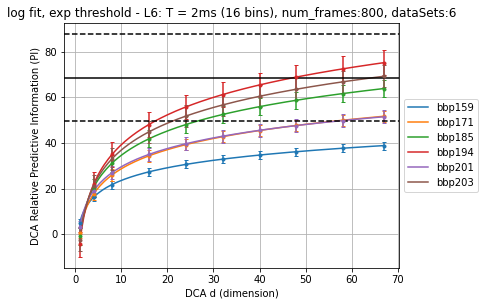

({'bbp159': [2188.0, 2720.0, 3382.0], 'bbp171': [221.0, 271.0, 333.0], 'bbp185': [72.0, 92.0, 117.0], 'bbp194': [36.0, 48.0, 64.0], 'bbp201': [233.0, 297.0, 378.0], 'bbp203': [49.0, 65.0, 87.0]}, {'bbp159': 3.0690957846166915, 'bbp171': 6.174153963269813, 'bbp185': 14.192405442452992, 'bbp194': 29.438038085566593, 'bbp201': 7.812634958162605, 'bbp203': 24.09510149109444})


In [21]:
print(curve_fit_parameterized_plot_DCA_vs_PI(L1_SAMPLE, 'L1', fit='log', normalizer='unnorm', include_fit=False, show_violins=True))
print(curve_fit_parameterized_plot_DCA_vs_PI(L23_SAMPLE, 'L23', fit='log', normalizer='unnorm', include_fit=False, show_violins=True))
print(curve_fit_parameterized_plot_DCA_vs_PI(L4_SAMPLE, 'L4', fit='log', normalizer='unnorm', include_fit=False, show_violins=True))
print(curve_fit_parameterized_plot_DCA_vs_PI(L5_SAMPLE, 'L5', fit='log', normalizer='unnorm', include_fit=False, show_violins=True))
print(curve_fit_parameterized_plot_DCA_vs_PI(L6_SAMPLE, 'L6', fit='log', normalizer='unnorm', include_fit=False, show_violins=True))

### 2.2.2 Using Exponential Fits to visualize the crossings

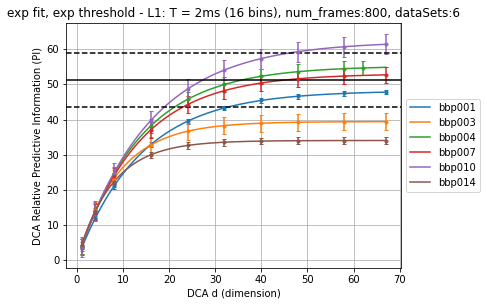

({'bbp001': [inf, inf, inf], 'bbp003': [inf, inf, inf], 'bbp004': [30.0, 36.0, 46.0], 'bbp007': [34.0, 45.0, inf], 'bbp010': [24.0, 28.0, 32.0], 'bbp014': [inf, inf, inf]}, {'bbp001': 0.43374163247057607, 'bbp003': 5.884128488975214, 'bbp004': 4.271224777542583, 'bbp007': 5.326639838275412, 'bbp010': 8.084291665041842, 'bbp014': 0.8870289435273707})


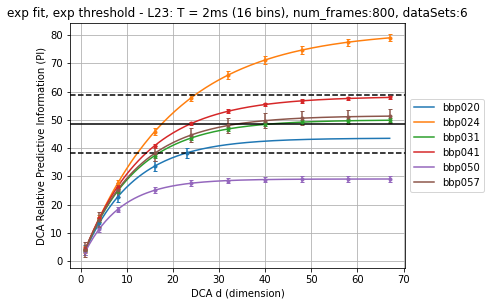

({'bbp020': [inf, inf, inf], 'bbp024': [17.0, 18.0, 19.0], 'bbp031': [38.0, 42.0, 51.0], 'bbp041': [23.0, 24.0, 25.0], 'bbp050': [inf, inf, inf], 'bbp057': [27.0, 35.0, 61.0]}, {'bbp020': 3.0296055023832253, 'bbp024': 1.5708181989097993, 'bbp031': 0.48902807334776155, 'bbp041': 0.44526657797527713, 'bbp050': 1.0345876415845956, 'bbp057': 6.433156344375979})


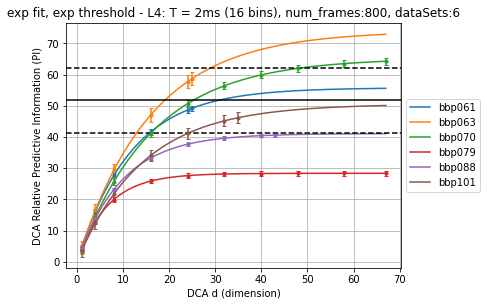

({'bbp061': [29.0, 31.0, 34.0], 'bbp063': [18.0, 19.0, 21.0], 'bbp070': [24.0, 26.0, 27.0], 'bbp079': [inf, inf, inf], 'bbp088': [inf, inf, inf], 'bbp101': [64.0, inf, inf]}, {'bbp061': 0.6786174391415191, 'bbp063': 4.554378384389228, 'bbp070': 1.217627781641217, 'bbp079': 0.5622645457193204, 'bbp088': 0.3400165974029759, 'bbp101': 3.0889748719530115})


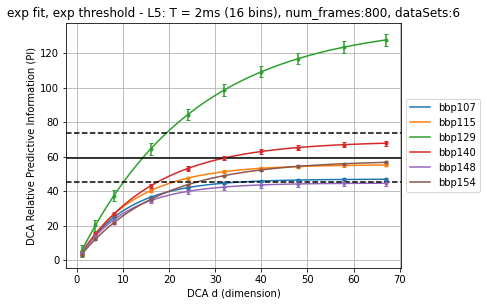

({'bbp107': [inf, inf, inf], 'bbp115': [inf, inf, inf], 'bbp129': [14.0, 15.0, 16.0], 'bbp140': [31.0, 33.0, 35.0], 'bbp148': [inf, inf, inf], 'bbp154': [inf, inf, inf]}, {'bbp107': 0.3628669214245747, 'bbp115': 0.6253438265341644, 'bbp129': 10.66614329147208, 'bbp140': 1.8103192412015816, 'bbp148': 2.6465306472131322, 'bbp154': 0.276682565301022})


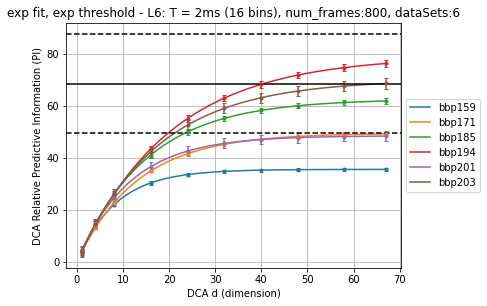

({'bbp159': [inf, inf, inf], 'bbp171': [inf, inf, inf], 'bbp185': [inf, inf, inf], 'bbp194': [39.0, 41.0, 44.0], 'bbp201': [inf, inf, inf], 'bbp203': [53.0, 67.0, inf]}, {'bbp159': 0.3915400103890418, 'bbp171': 0.22285355683406846, 'bbp185': 1.037068443293313, 'bbp194': 1.639893838677345, 'bbp201': 3.6441134457928297, 'bbp203': 3.7640885845024346})


In [22]:
print(curve_fit_parameterized_plot_DCA_vs_PI(L1_SAMPLE, 'L1', fit='exp', normalizer='unnorm', include_fit=False, show_violins=True))
print(curve_fit_parameterized_plot_DCA_vs_PI(L23_SAMPLE, 'L23', fit='exp', normalizer='unnorm', include_fit=False, show_violins=True))
print(curve_fit_parameterized_plot_DCA_vs_PI(L4_SAMPLE, 'L4', fit='exp', normalizer='unnorm', include_fit=False, show_violins=True))
print(curve_fit_parameterized_plot_DCA_vs_PI(L5_SAMPLE, 'L5', fit='exp', normalizer='unnorm', include_fit=False, show_violins=True))
print(curve_fit_parameterized_plot_DCA_vs_PI(L6_SAMPLE, 'L6', fit='exp', normalizer='unnorm', include_fit=False, show_violins=True))

## 2.2.3 Curve Fit overlaid with ground-truth data
In the graphs below, we plot all the ground truth data provided for every cell of a given type, and the curve fit to the aggregate (i.e. the average) along with the threshold. The errors on threshold are computed in the same way as described above.

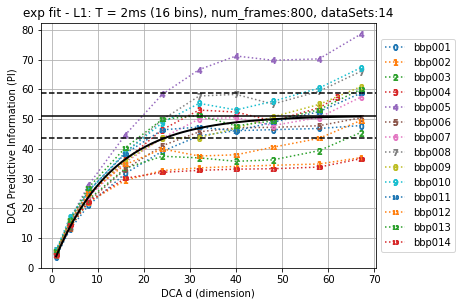

In [23]:
%matplotlib inline

L1 = SORTED_CELL_TYPES['L1'] # ['bbp001', 'bbp003', 'bbp004', 'bbp007', 'bbp010', 'bbp014']
curve_fit_plot_DCA_vs_PI(L1, 'L1', threshold_fit='exp', normalizer='unnorm')
# curve_fit_plot_DCA_vs_PI(L1, cell_type = 'L1', fit='tanh', normalizer='unnorm')
# curve_fit_plot_DCA_vs_PI(L1, cell_type = 'L1', fit='rat', normalizer='unnorm')

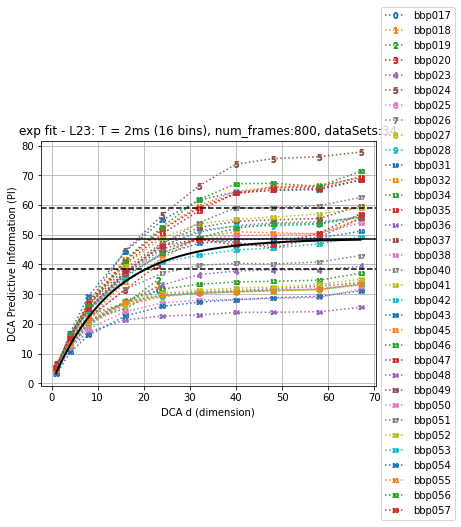

In [24]:
%matplotlib inline

L23 = SORTED_CELL_TYPES['L23'] # ['bbp020', 'bbp024', 'bbp031', 'bbp041', 'bbp050', 'bbp057']

curve_fit_plot_DCA_vs_PI(L23, cell_type = 'L23', threshold_fit='exp', normalizer='unnorm')
# curve_fit_plot_DCA_vs_PI(L23, cell_type = 'L23', fit='rat', normalizer='unnorm')
# curve_fit_plot_DCA_vs_PI(L23, cell_type = 'L23', fit='tanh', normalizer='unnorm')

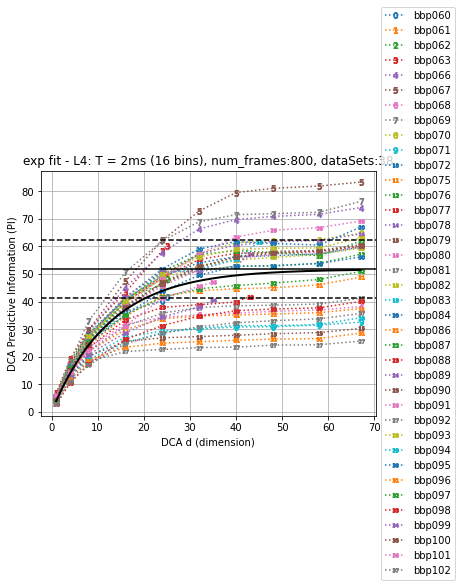

In [25]:
%matplotlib inline

L4 = SORTED_CELL_TYPES['L4'] # ['bbp061', 'bbp063', 'bbp070', 'bbp079', 'bbp088', 'bbp101']

curve_fit_plot_DCA_vs_PI(L4, cell_type = 'L4', threshold_fit='exp', normalizer='unnorm')
# curve_fit_plot_DCA_vs_PI(L4, cell_type = 'L4', fit='rat', normalizer='unnorm')
# curve_fit_plot_DCA_vs_PI(L4, cell_type = 'L4', fit='tanh', normalizer='unnorm')

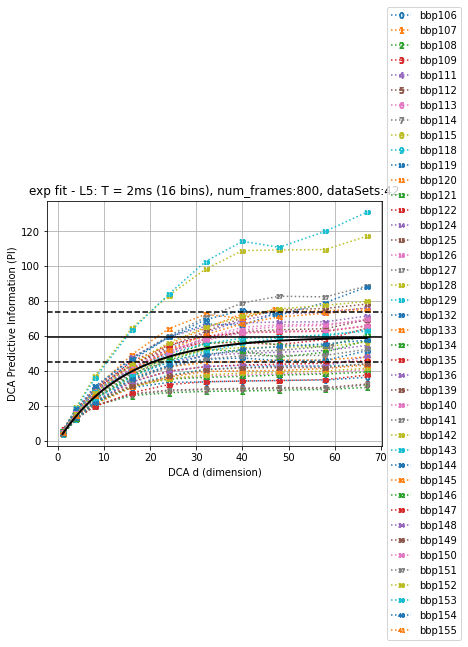

In [26]:
%matplotlib inline

L5 = SORTED_CELL_TYPES['L5'] # ['bbp107', 'bbp115', 'bbp129', 'bbp140', 'bbp148', 'bbp154']

curve_fit_plot_DCA_vs_PI(L5, cell_type = 'L5', threshold_fit='exp', normalizer='unnorm')
# curve_fit_plot_DCA_vs_PI(L5, cell_type = 'L5', fit='rat', normalizer='unnorm')
# curve_fit_plot_DCA_vs_PI(L5, cell_type = 'L5', fit='tanh', normalizer='unnorm')

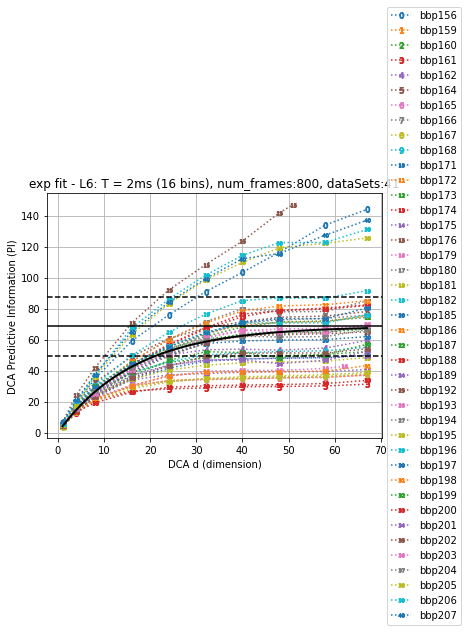

In [27]:
%matplotlib inline

L6 = SORTED_CELL_TYPES['L6'] # ['bbp159', 'bbp171', 'bbp185', 'bbp194', 'bbp201', 'bbp203']

curve_fit_plot_DCA_vs_PI(L6, cell_type = 'L6', threshold_fit='exp', normalizer='unnorm')
# curve_fit_plot_DCA_vs_PI(L6, cell_type = 'L6', fit='rat', normalizer='unnorm')
# curve_fit_plot_DCA_vs_PI(L6, cell_type = 'L6', fit='tanh', normalizer='unnorm')

### 2.2.4 Curve-fitting Singular Neurons
Below are the DCA vs PI graphs with curves fitted to single neurons, to see if rational fit is better or worse than log fit. Our findings show that exponential fits have the least mean squared error. 

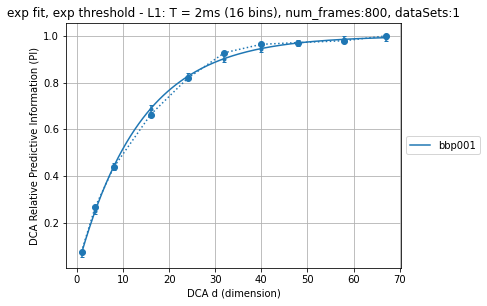

({'bbp001': [59.0, inf, inf]}, {'bbp001': 0.0002072598377827852})


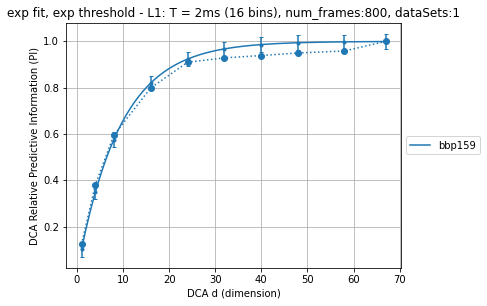

({'bbp159': [33.0, inf, inf]}, {'bbp159': 0.0009795362024731058})


In [28]:
%matplotlib inline

print(curve_fit_parameterized_plot_DCA_vs_PI(['bbp001'], 'L1', fit='exp', normalizer='maxavg', include_thresh=False,
                                             include_fit=False, show_violins=True, include_ground_truth=True))
print(curve_fit_parameterized_plot_DCA_vs_PI(['bbp159'], 'L1', fit='exp', normalizer='maxavg', include_thresh=False,
                                             include_fit=False, show_violins=True, include_ground_truth=True))

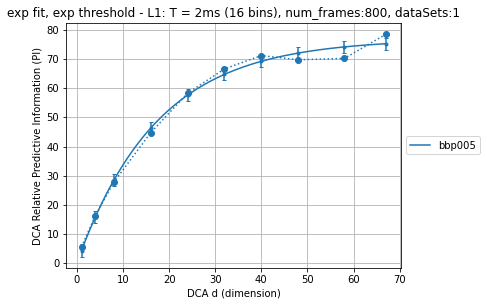

({'bbp005': [18.0, 19.0, 21.0]}, {'bbp005': 4.403251073860885})


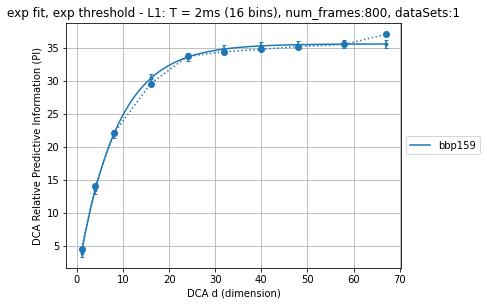

({'bbp159': [inf, inf, inf]}, {'bbp159': 0.3915400103890418})


In [29]:
%matplotlib inline

print(curve_fit_parameterized_plot_DCA_vs_PI(['bbp005'], 'L1', fit='exp', normalizer='unnorm', include_thresh=False,
                                             include_fit=False, show_violins=True, include_ground_truth=True))
print(curve_fit_parameterized_plot_DCA_vs_PI(['bbp159'], 'L1', fit='exp', normalizer='unnorm', include_thresh=False,
                                             include_fit=False, show_violins=True, include_ground_truth=True))

## 2.3 Normalized Mutual Information
To offer a more robust comparison between cells, we compute the normalized mutual information. Given two random variables $X$ and $Y$, there is no agreed upon notion in literature for how such a quantity should be measured. However, all of them take the form 
$$I_{norm}(X;Y) = \frac{I(X;Y)}{f(X,Y)},$$
where $f$ is some function. The following paper (https://arxiv.org/abs/1110.2515) suggests that since
\begin{align*}
I(X;Y) &\le \min(H(X), H(Y)) \\
&\le \sqrt{H(X)H(Y)} \\
&\le \frac12(H(X)+H(Y))\\
&\le \max(H(X),H(Y)) \\
\end{align*}
$f$ can take on any of the expressions on the right hand side. The paper uses the so-called normalized information distance, which uses the choice $f(X,Y) = \max(H(X), H(Y))$. We will see that in our case, the choice of $f$ is irrelevant. 

Following the notation in DCA PAPER, let $X=\{x_t\}$ with $x_t\in\mathbb{R}^n$ be a discrete time series with stationary probability distribution $P(X)$. The predictive information is calculated to be $$I_T^{pred}(X) = 2H_X(T) - H_X(2T).$$
However, the all four options for $f$ agree with each other since $H(X_{past}) = H(X_{future}) = H_X(T)$ by the stationarity assumption. Thus, the normalized predictive information is
\begin{align*}
I_T^{norm}(X) &= \frac{I_T^{pred}(X)}{H_X(T)} = 2 - \frac{H_X(2T)}{H_X(T)}.
\end{align*}


# 3. DCA Dimension vs Predictive Information Graphs (300-700 Frame Average)

The following is largely unused code to plot and graph some of the other data provided by Jan Balewski. Ultimately, nothing in this section was used. 

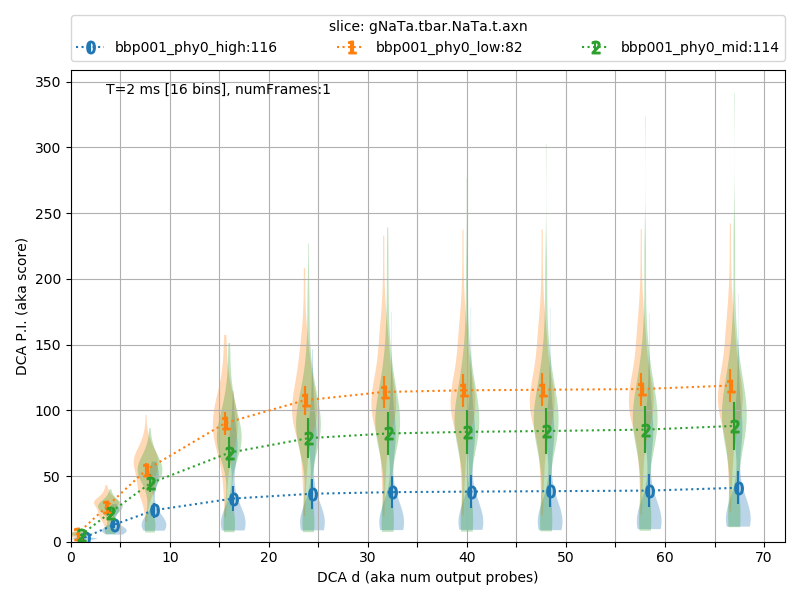

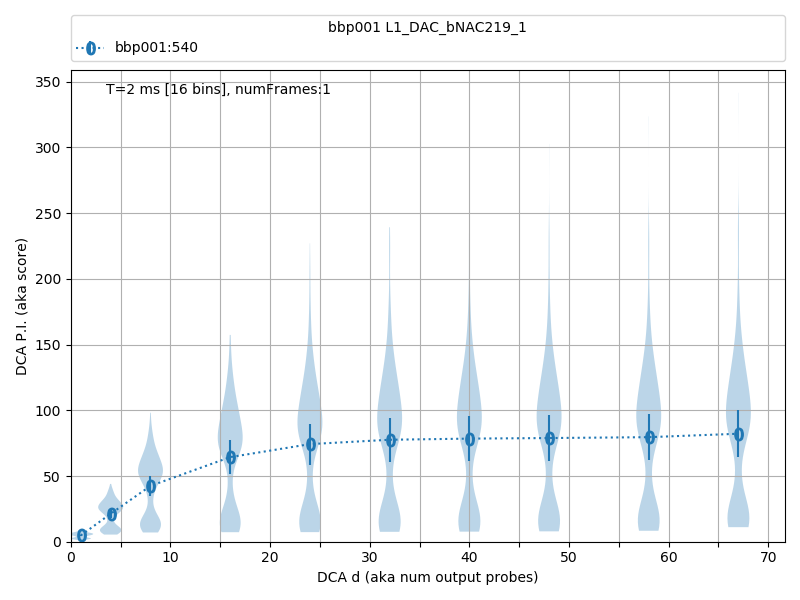

In [30]:
def view_cell_DCA_vs_PI(cell_name):
    directory_path = DCA_300_TO_700FRAME_DATA_CSV_DIR + cell_name
    image_files = [file for file in os.listdir(directory_path) if file.endswith('.png')]
    for file in image_files:
        display(Image(directory_path + "/" + file))
    
view_cell_DCA_vs_PI("bbp001")

In [31]:
def read_cell_yaml(cell):
    yaml_filename = DCA_300_TO_700FRAME_DATA_CSV_DIR + cell + "/pi1frame_" + cell + ".yaml"
    file = open(yaml_filename, 'r')
    data = yaml.load(file, Loader=yaml.CLoader)
    file.close()
    return data

def graph_DCA_vs_PI_framewise(cell, img_width=6, img_height=4.5):
    dca_to_pi_perframe = read_cell_yaml(cell)['score'][cell]
    # mean PI per DCA d, set of all given DCA d values, and std of
    # PI per DCA d provided
    mean_pi = []
    avail_dims = []
    std_pi = []
    for dim in dca_to_pi_perframe.keys():
        mean_pi.append(np.mean(dca_to_pi_perframe[dim]))
        avail_dims.append(dim)
        std_pi.append(0.5 * np.std(dca_to_pi_perframe[dim]))
        
    plt.figure(figsize=(img_width, img_height))
    plt.violinplot(list(dca_to_pi_perframe.values()), positions=avail_dims, widths=2, showextrema=False)
    plt.plot(avail_dims, mean_pi, linestyle='dotted', marker='$0$', markersize=10, label=cell, color='b')
    plt.errorbar(avail_dims, mean_pi, yerr=std_pi, fmt='', linestyle='dotted',color='b')
    plt.title('T = 2ms ({} bins), num_frames:{}'.format(16, 1))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

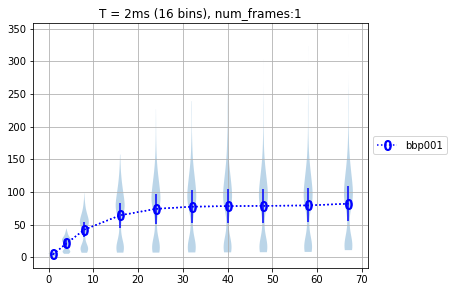

In [32]:
graph_DCA_vs_PI_framewise('bbp001')

# 4 Scatterplot and Clustering of Cell Types

The first step in constructing the scatter plot is to calculate for each cell a threshold for maximal predictive information. This is done by using an exponential fit to the data and taking the asymptote to be threshold for max PI for that individual cell. Then, we calculate the first DC-level for which the predicted PI of the cell is equal to the calculated threshold within error (error here is calculated by taking the square root of the MSE of the exponential fit). 

For calculating the DC-level we have a flag use_integer_DCA which will essentially force the DCA-level for the cell to be an integer by taking the ceiling of the value derived from setting the parametric curve equal to the threshold minus the error. 

## 4.1 Table Generation per Cell Type
For all the cells of a given cell type, we compute the threshold of predictive information for the cell (i.e. the asymptote of the curve-fit to the data of that individual neuron, in this case exponential), the mean squared error, the DCA level at which the threshold is crossed as well as the predictive information at that level. We've also added a column labeld info_per_dc, which computes the predictive information divided by the dca level at which the threshold was crossed. This was intended to measure how many bits on average each dynamical component provides, but it proved to be rather useless in sorting cells by complexity.

In [33]:
def generate_DCA_vs_PI_by_type(cell_type, fit='exp', normalizer='unnorm', use_integer_DCA=True, use_error=False):
    dca_pi_thresh_by_cell = []
    
    for cell in SORTED_CELL_TYPES[cell_type]:
        param_data_cell = curve_fit_params_DCA_vs_PI([cell], fit=fit, normalizer=normalizer)     
        error_cell = np.sqrt(param_data_cell['MSE'])
        fit_params = param_data_cell['params']
        threshold = param_data_cell['threshold']
        
        dca_pi_thresh_current_cell = [cell, threshold, error_cell]
                
        if fit == 'exp':            
            if use_integer_DCA:
                A, B = fit_params
                if use_error:
                    dca_lvl = np.ceil(-1 / B * np.log(1 - (threshold - error_cell) / A))
                else:
                    dca_lvl = np.ceil(-1 / B * np.log(1 - (0.99 * threshold) / A))
            else:
                A, B = fit_params
                if use_error:
                    dca_lvl = -1 / B * np.log(1 - (threshold - error_cell) / A)
                else:
                    dca_lvl = -1 / B * np.log(1 - (0.99 * threshold) / A)
            # append dca_lvl and the PI value corresponding to dca_lvl
            pi = A * (1 - np.exp(- B * dca_lvl))
            dca_pi_thresh_current_cell.append(dca_lvl)
            dca_pi_thresh_current_cell.append(pi)
            dca_pi_thresh_current_cell.append(pi / dca_lvl)
            
        dca_pi_thresh_by_cell.append(dca_pi_thresh_current_cell)      
    return pd.DataFrame(dca_pi_thresh_by_cell, columns=['cell_name', 'threshold', 'error', 'dca_level', 'pi', 'info_per_dc']).sort_values(by=['info_per_dc'])


In [34]:
print(generate_DCA_vs_PI_by_type('L1', fit='exp'))

   cell_name  threshold     error  dca_level         pi  info_per_dc
0     bbp001  48.198179  0.658591       65.0  47.735010     0.734385
8     bbp009  55.378809  3.163235       73.0  54.842540     0.751268
5     bbp006  49.450307  0.844068       63.0  48.983377     0.777514
9     bbp010  62.297388  2.843289       73.0  61.687285     0.845031
6     bbp007  53.064838  2.307951       62.0  52.550914     0.847595
3     bbp004  55.257165  2.066694       63.0  54.712701     0.868456
7     bbp008  62.593230  2.475157       71.0  61.984029     0.873014
1     bbp002  34.984068  0.765580       39.0  34.660723     0.888736
10    bbp011  52.709311  2.681973       58.0  52.216214     0.900280
2     bbp003  39.419852  2.425722       42.0  39.045894     0.929664
4     bbp005  76.893477  2.098392       80.0  76.132304     0.951654
11    bbp012  42.589022  2.891850       44.0  42.195988     0.959000
13    bbp014  34.039473  0.941822       35.0  33.709619     0.963132
12    bbp013  53.941824  2.851691 

In [35]:
print(generate_DCA_vs_PI_by_type('L23', fit='exp'))

   cell_name  threshold     error  dca_level         pi  info_per_dc
30    bbp054  29.350813  0.753661       48.0  29.067473     0.605572
4     bbp023  38.905359  0.622077       55.0  38.518826     0.700342
26    bbp050  29.083432  1.017147       38.0  28.820710     0.758440
21    bbp045  53.819963  1.506744       69.0  53.287574     0.772284
12    bbp034  34.972424  0.876320       44.0  34.654136     0.787594
8     bbp027  31.484718  0.657201       39.0  31.194037     0.799847
27    bbp051  62.891073  1.293209       77.0  62.296280     0.809043
24    bbp048  23.897316  0.712338       29.0  23.678693     0.816507
14    bbp036  32.224657  0.721285       39.0  31.917600     0.818400
22    bbp046  55.446151  1.070164       67.0  54.898053     0.819374
6     bbp025  31.593995  0.688080       38.0  31.285423     0.823301
28    bbp052  32.942872  0.859485       39.0  32.613823     0.836252
13    bbp035  70.216785  1.295155       83.0  69.532125     0.837736
17    bbp040  41.471433  0.737112 

In [36]:
print(generate_DCA_vs_PI_by_type('L4', fit='exp'))

   cell_name  threshold     error  dca_level         pi  info_per_dc
33    bbp098  38.970920  0.612612       65.0  38.582713     0.593580
37    bbp102  34.026221  0.835971       56.0  33.692908     0.601659
34    bbp099  40.814592  1.504229       54.0  40.416248     0.748449
29    bbp094  31.839013  1.050330       42.0  31.530399     0.750724
36    bbp101  50.582226  1.757548       66.0  50.086520     0.758887
26    bbp091  71.156938  1.394458       90.0  70.465437     0.782949
16    bbp080  59.485214  0.910077       72.0  58.922708     0.818371
30    bbp095  55.461903  1.272250       67.0  54.915177     0.819630
35    bbp100  60.321702  0.769100       72.0  59.744071     0.829779
25    bbp090  60.507095  1.061633       72.0  59.919176     0.832211
17    bbp081  39.622878  0.618062       47.0  39.242144     0.834939
9     bbp071  31.280726  0.499442       37.0  30.972030     0.837082
31    bbp096  26.445994  0.834101       31.0  26.195384     0.845012
27    bbp092  24.031331  0.697430 

In [37]:
print(generate_DCA_vs_PI_by_type('L5', fit='exp'))

   cell_name   threshold     error  dca_level          pi  info_per_dc
40    bbp154   57.832630  0.526006       79.0   57.282266     0.725092
39    bbp153   63.442250  0.940844       86.0   62.830519     0.730587
9     bbp118   43.649689  0.264052       56.0   43.230333     0.771970
33    bbp147   35.427163  1.041720       45.0   35.075227     0.779449
41    bbp155   78.596301  0.688969       99.0   77.810875     0.785968
31    bbp145   41.709178  1.151210       52.0   41.320194     0.794619
13    bbp122   45.220374  0.445045       55.0   44.803150     0.814603
35    bbp149   42.845343  0.812794       52.0   42.433568     0.816030
14    bbp124   79.017702  1.407098       95.0   78.255490     0.823742
22    bbp134   38.300596  0.492295       45.0   37.924323     0.842763
15    bbp125   81.085541  1.470154       95.0   80.305853     0.845325
5     bbp112   30.767051  0.651527       36.0   30.473508     0.846486
37    bbp151   50.569285  1.162780       59.0   50.087901     0.848947
7     

In [38]:
print(generate_DCA_vs_PI_by_type('L6', fit='exp'))

   cell_name   threshold     error  dca_level          pi  info_per_dc
28    bbp195   37.238005  0.828394       49.0   36.898679     0.753034
16    bbp179   41.640925  0.736012       53.0   41.254656     0.778390
33    bbp200   31.495979  0.943690       39.0   31.208917     0.800229
10    bbp171   49.586190  0.472074       61.0   49.118901     0.805228
35    bbp202   53.663368  0.994148       66.0   53.146431     0.805249
31    bbp198   40.725088  1.279797       50.0   40.349343     0.806987
25    bbp192   67.050254  1.186918       80.0   66.409447     0.830118
27    bbp194   79.258854  1.280583       93.0   78.481075     0.843883
8     bbp167   36.256875  0.673143       42.0   35.921184     0.855266
13    bbp174   87.293799  1.212338      101.0   86.422605     0.855669
18    bbp181   46.799873  0.748614       54.0   46.356740     0.858458
26    bbp193   71.214553  1.231549       82.0   70.527039     0.860086
23    bbp188   86.906229  1.552581      100.0   86.075141     0.860751
12    

## 4.2 Scatterplot of Cell Types
Using the table above, we can assign to each neuron a pair $(d, I)$, where $d$ is the number of dynamical components to cross the threshold and $I$ is the predictive information at that threshold. The following code creates a scatter plot and appends a line of best fit to the diagram.

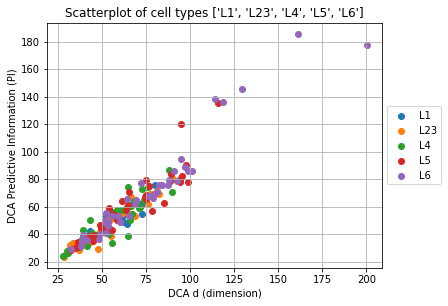

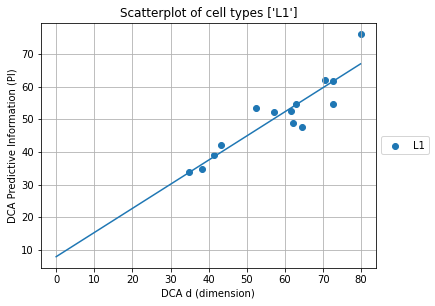

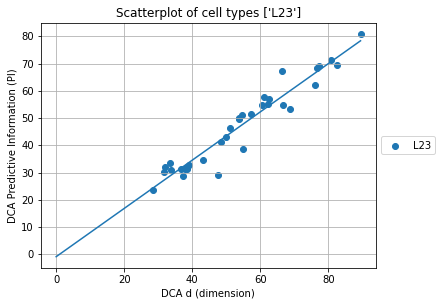

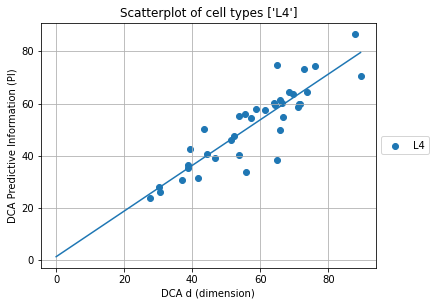

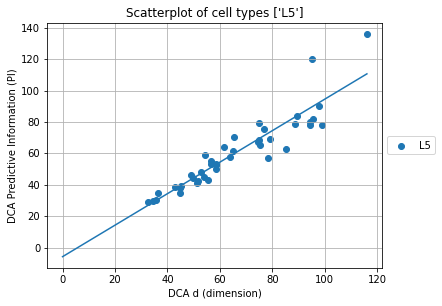

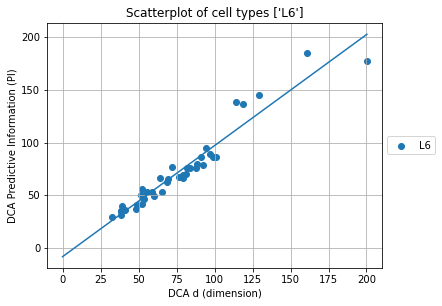

In [39]:
def line_of_best_fit(cell_type, normalizer='unnorm', use_integer_DCA=True):
    data_cell_type = generate_DCA_vs_PI_by_type(cell_type, use_integer_DCA=use_integer_DCA)
    # y = mx + b
    m, b = np.polyfit(data_cell_type['dca_level'], data_cell_type['pi'], 1)
    return m, b

def generate_scatter_plot_DCA_vs_PI_by_type(cell_types_to_plot, normalizer='unnorm', use_integer_DCA=True, 
                                            img_width=6, img_height=4.5, show_line_best_fit=False):
    
    colors_to_use = []
    max_dca = 0
    
    plt.figure(figsize=(img_width, img_height))
    for cell_type in cell_types_to_plot:
        data_cell_type = generate_DCA_vs_PI_by_type(cell_type, use_integer_DCA=use_integer_DCA)
        plt.scatter(data_cell_type['dca_level'], data_cell_type['pi'], label=cell_type)
        max_dca = max(data_cell_type['dca_level'].max(), max_dca)
        colors_to_use.append(plt.gca().collections[-1].get_facecolor())
        
    color_index = 0
    if show_line_best_fit:
        for cell_type in cell_types_to_plot:
            m, b = line_of_best_fit(cell_type, normalizer=normalizer, use_integer_DCA=use_integer_DCA)
            x_plt = np.linspace(0, max_dca, 300)
            plt.plot(x_plt, m * x_plt + b, color=colors_to_use[color_index])
            color_index += 1
        
    plt.title('Scatterplot of cell types ' + str(cell_types_to_plot))
    plt.xlabel('DCA d (dimension)')
    plt.ylabel('DCA Predictive Information (PI)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

generate_scatter_plot_DCA_vs_PI_by_type(['L1', 'L23', 'L4', 'L5', 'L6'], use_integer_DCA=False, show_line_best_fit=False)
generate_scatter_plot_DCA_vs_PI_by_type(['L1'], use_integer_DCA=False, show_line_best_fit=True)
generate_scatter_plot_DCA_vs_PI_by_type(['L23'], use_integer_DCA=False, show_line_best_fit=True)
generate_scatter_plot_DCA_vs_PI_by_type(['L4'], use_integer_DCA=False, show_line_best_fit=True)
generate_scatter_plot_DCA_vs_PI_by_type(['L5'], use_integer_DCA=False, show_line_best_fit=True)
generate_scatter_plot_DCA_vs_PI_by_type(['L6'], use_integer_DCA=False, show_line_best_fit=True)

The following tuples of the form $(m,b)$ represent a line of best fit of the form $y=mx+b$ that fits the data of that cell_type. It makes sense that L6 is the largest.

In [40]:
print(line_of_best_fit('L1'))
print(line_of_best_fit('L23'))
print(line_of_best_fit('L4'))
print(line_of_best_fit('L5'))
print(line_of_best_fit('L6'))

(0.7428908445561091, 7.426337873177274)
(0.8866777604006041, -1.331695860241265)
(0.8744576868093685, 1.054453491688182)
(1.0021644184060712, -6.190705140705273)
(1.057075270572353, -9.199962905024528)


The next step of the analysis is to graph the cell type (L1, L23, etc) against the average mutual 